# PO-4

Section 1: File processing

* TO-DO: 

-----

## Table of Contents

* [1. Introduction](#introduction)
    * [1.1 Description](#project-description)
    * [1.2 Packages](#packages)
        
 
* [2. Data Loading](#data-loading)
    * [2.1 Loading WT and KO initial files](#loading-wt-and-ko-initial-files)
    * [2.2 Loading Uniprot reference proteome](#loading-uniprot-reference-proteome)
    

* [3. Data Preprocessing](#data-preprocessing)
    * [3.1 Generating Kmers](#generating-kmers)
    * [3.2 Processing peptide files](#processing-peptide-files)


* [4. Data Exploration](#data-exploration)
    * [4.1 Generating Kmers](#generating-kmers)
    * [4.2 Processing peptide files](#processing-peptide-files)


* [5. References](#references)

* [6. Project contribution](#project-contribution)

-----

# 1. Introduction <a class="anchor" id="introduction"></a>

## 1.1 Description <a class="anchor" id="project-description"></a>

#### How can we define phosphoproteomics ? 

Phosphoproteomics is a branch of proteomics that identifies, catalogs, and characterizes proteins containing a phosphate group as a posttranslational modification. Phosphorylation is a key reversible modification that regulates protein function, subcellular localization, complex formation, degradation of proteins and therefore cell signaling networks. With all of these modification results, it is estimated that between 30%–65% of all proteins may be phosphorylated, some multiple times. Based on statistical estimates from many datasets, 230,000, 156,000 and 40,000 phosphorylation sites should exist in human, mouse, and yeast, respectively.

Compared to expression analysis, phosphoproteomics provides two additional layers of information. First, it provides clues on what protein or pathway might be activated because a change in phosphorylation status almost always reflects a change in protein activity. Second, it indicates what proteins might be potential drug targets. While phosphoproteomics will greatly expand knowledge about the numbers and types of phosphoproteins, its greatest promise is the rapid analysis of entire phosphorylation based signalling networks.

Below, we are going to analyse Wild-type (WT) THP-1 against THP-1 Knockout (KO) Cell line

Doubts to comment: 
- Are we going to allow accounting for duplicated 13-mers? There are a lot of duplicated peptides.

Some useful resources for the forthcoming analysis:

- Motif analysis tools: https://molbiol-tools.ca/Motifs.htm
- PTM code: https://ptmcode.embl.de/version1/index.cgi
- MEME suite: http://meme-suite.org/tools/meme
- NetPhos: http://www.cbs.dtu.dk/services/NetPhos/
- Protein bioinformatics book.
- ProtVista sequence viewer (PDB): https://wwwdev.ebi.ac.uk/pdbe/entry/pdb/3bow/protein/3

First of all, we need to import some Python libraries

## 1.2 Packages

In [2]:
import os, sys
from math import log2
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../src/')
from utils import * 

warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

%load_ext autoreload
%autoreload 2

%load_ext watermark
%watermark -a 'Fernando Pozo' -u -n -t -z -g -p pandas,numpy,matplotlib

!pwd

Fernando Pozo 
last updated: Fri Sep 11 2020 16:48:29 CEST 

pandas 1.0.4
numpy 1.18.5
matplotlib 3.2.1
Git hash: cefe14675e7c07123ef09f36d71551826a082e93
/local/fpozoc/projects/dev/ph-proteomics/notebooks


-----

# 2. Data Loading <a class="anchor" id="data-loading"></a>

Loading data from original files

## 2.1 Loading WT and KO initial files

In [3]:
df_wt = pd.read_excel('../data/external/files/September_2018_Julio_WT_TC_1-48_rep_replicate3_20180921s_with_LP.xlsx')
df_ko = pd.read_excel('../data/external/files/Julio_KO_PO4_1-30_20170921_Final_PEPTIDE.xlsx')

In [18]:
pwt = df_wt[['peptide', 'proteinName', 'ac', 'ptm', 'FTestQValue']]
pwt.rename(columns={'FTestQValue': 'FTestQValueWT'}, inplace=True)

pko = df_ko[['peptide', 'proteinName', 'ac', 'ptm', 'FTestQValue']]
pko.rename(columns={'FTestQValue': 'FTestQValueKO'}, inplace=True)

df_peptides = pd.merge(pwt,pko,how='inner', on=['peptide', 'proteinName', 'ac', 'ptm'])
df_peptides['FTestQValueWTvsKO'] = df_peptides['FTestQValueKO'] - df_peptides['FTestQValueWT']
# df_peptides = df_peptides.loc[
#     (df_peptides['FTestQValueWT'] < 0.05) & (df_peptides['FTestQValueKO'] > 0.05) |
#     (df_peptides['FTestQValueWT'] > 0.05) & (df_peptides['FTestQValueKO'] < 0.05)                             
#                              ].reset_index(drop=True)
df_peptides = df_peptides.loc[(df_peptides['FTestQValueWT'] < 0.05)]
df_peptides = df_peptides.sort_values(by='FTestQValueWTvsKO', ascending=False)
df_peptides.to_csv('../data/processed/ftestqvaluewtvsko.tsv.gz', sep='\t', compression='gzip', index=None)

In [20]:
df_peptides.head()

,peptide,proteinName,ac,ptm,FTestQValueWT,FTestQValueKO,FTestQValueWTvsKO
1258,ALGSPTK,sp|Q9NR45|SIAS_HUMAN,Q9NR45,[4] Phospho (ST),7.840138e-06,0.999840,0.999832
1779,GISPIVFDR,sp|Q96MU7|YTDC1_HUMAN,Q96MU7,[3] Phospho (ST),1.007342e-04,0.999840,0.999740
847,RIDISPSTFR,sp|Q9Y2W1|TR150_HUMAN,Q9Y2W1,[5] Phospho (ST),5.327072e-07,0.998900,0.998900
1257,TPSPKEEDEEPESPPEK,sp|Q9H1E3|NUCKS_HUMAN,Q9H1E3,[13] Phospho (ST),7.770864e-06,0.998757,0.998749
2132,IDISPSTLR,sp|Q9NYF8|BCLF1_HUMAN,Q9NYF8,[4] Phospho (ST),3.834320e-04,0.999042,0.998659


In [21]:
# df_wt = pd.merge(df_wt, df_peptides[['peptide', 'proteinName', 'ac', 'ptm', 'FTestQValueWTvsKO']], on = ['peptide', 'proteinName', 'ac', 'ptm'], how='left')
# df_ko = pd.merge(df_ko, df_peptides[['peptide', 'proteinName', 'ac', 'ptm', 'FTestQValueWTvsKO']], on = ['peptide', 'proteinName', 'ac', 'ptm'], how='left')

In [22]:
print(f'There are {df_wt.shape[0]} wilt-type peptides.')
print(f'There are {df_ko.shape[0]} knock-out peptides.')

There are 13556 wilt-type peptides.
There are 10614 knock-out peptides.


In [23]:
df_wt = df_wt[df_wt['FTestQValue']<0.05].reset_index(drop=True)
df_ko = df_ko[df_ko['FTestQValue']<0.05].reset_index(drop=True)

In [24]:
print(f'Removing peptides with q-value lower than 0.05:\n')
print(f'There are {df_wt.shape[0]} wilt-type peptides.')
print(f'There are {df_ko.shape[0]} knock-out peptides.')

Removing peptides with q-value lower than 0.05:

There are 7152 wilt-type peptides.
There are 2840 knock-out peptides.


## 2.2 Loading [UniProt reference proteome](https://www.uniprot.org/proteomes/UP000005640)

In [25]:
df_fastas = load_fasta('../data/raw/uniprot/uniprot-proteome-3AUP000005640.txt')
print(f'There are {df_fastas.shape[0]} different proteins in this version.')

Fasta shape = (71607, 4)
There are 71607 different proteins in this version.


-----

# 3. Data Preprocessing <a class="anchor" id="data-preprocessing"></a>

We have preprocessed the data in order to create this pandas DataFrames:
- `df_fastas`  contains protein sequences from Uniprot. Colnames -> *Index(['proteinName', 'proteinLen', 'proteinSeq'])*
- `df_motifs` contains all the 13-mers (------S/T/Y------) found in the data set of Uniprot protein sequences. Colnames -> *Index(['proteinName', 'res', 'kmer_start', 'kmer_end', 'kmer'])*
- `df_exptypes`: `wt` contains the wild-type peptides and `ko` contains the knock-out peptides from our experiment. Colnames -> *Index(['type', 'proteinName', 'geneName', 'n-ptm', 'res-ptm', 'proteinSeq-loc', 'proteinLen',  'peptide', 'kmer', 'proteinSeq'])*

## 3.1 Generating Kmers

13-mers (------S/T/Y------) were generated centrally locating S(ser|serine) T(thr|threonine) and Y(tyr|tyrosine)

In [26]:
motifs_s = generate_motifs(df=df_fastas, column='proteinSeq', aa='S')
motifs_t = generate_motifs(df=df_fastas, column='proteinSeq', aa='T')
motifs_y = generate_motifs(df=df_fastas, column='proteinSeq', aa='Y')
df_motifs = pd.concat([motifs_s, motifs_t, motifs_y]).sort_values(by=['proteinName', 'kmer_start', 'kmer_end', 'res']).reset_index(drop=True)

In [27]:
df_motifs.head(3)

,proteinName,res,kmer_start,kmer_end,kmer
0,A0A024QYW1,S,15,28,NKLCLVSMDFCFP
1,A0A024QYW1,S,26,39,FPLDFVSNVFWIF
2,A0A024QYW1,S,34,47,VFWIFASKFIIVT


## 3.2 Processing peptide files

We have applied 4 filters to quit motifs that are not interesting for our analysis, removing:
- Motifs with FTestQvalue higher than 0.05.
- Non-phospho (oxidation) motifs.

In [29]:
wt = process_peptides(df_wt, df_fastas, filetype='wt')
ko = process_peptides(df_ko, df_fastas, filetype='ko')

In [75]:
df_proportions = pd.concat([wt, ko]).reset_index(drop=True)
df_proportions = df_proportions[~df_proportions.duplicated(['peptide', 'proteinName', 'ptm', 'kmer'])][['res-ptm', 'type']]
df_proportions_wt = df_proportions.loc[df_proportions['type'] == 'wt']
df_proportions_wt = (df_proportions_wt['res-ptm'].value_counts(normalize=True)*100).reset_index().rename(columns={'index':'PTM residue', 'res-ptm':'Motif category proportion (WT)'})
df_proportions_ko = df_proportions.loc[df_proportions['type'] == 'ko']
df_proportions_ko = (df_proportions_ko['res-ptm'].value_counts(normalize=True)*100).reset_index().rename(columns={'index': 'PTM residue', 'res-ptm':'Motif category proportion (KO)'})
df_prop = pd.merge(df_proportions_wt, df_proportions_ko, how='outer', on='PTM residue').set_index('PTM residue')

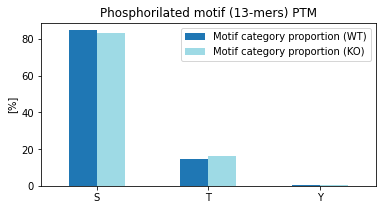

In [83]:
df_prop.plot.bar(rot=0, figsize=(6,3), colormap='tab20')
plt.xlabel('')
plt.ylabel('[%]')
plt.title('Phosphorilated motif (13-mers) PTM')
plt.savefig('../reports/figures/figure3B.png', bbox_inches='tight', dpi=360)

Has to be removed?
- Motifs that can't build a 13-mer. 
- Repeated phosphorilation sites

In [30]:
print(f"There are {wt.shape[0]} wild-type phosphorilation sites, with {wt['proteinName'].nunique()} different proteins.")
print(f"There are {ko.shape[0]} knock-out phosphorilation sites, with {ko['proteinName'].nunique()} different proteins.")

print(f"\nThere are {wt.duplicated(['peptide', 'proteinName', 'ptm', 'kmer']).sum()} ({round(wt.duplicated(['peptide', 'proteinName', 'ptm', 'kmer']).sum()/wt.shape[0], 5)*100} %) repeated wild-type phosphorilation sites.")
print(f"There are {ko.duplicated(['peptide', 'proteinName', 'ptm', 'kmer']).sum()} ({round(ko.duplicated(['peptide', 'proteinName', 'ptm', 'kmer']).sum()/ko.shape[0], 6)*100} %) repeated knockout phosphorilation sites.")

There are 8472 wild-type phosphorilation sites, with 2478 different proteins.
There are 3208 knock-out phosphorilation sites, with 1398 different proteins.

There are 1068 (12.606 %) repeated wild-type phosphorilation sites.
There are 185 (5.7668 %) repeated knockout phosphorilation sites.


#### Wild-type file sample 1

In [31]:
wt.iloc[0]

peptide                     APESPPSADPALVAGPAEEAECPPPRQPQPAQNVLAAPR
proteinName                                                  Q6EEV4
geneName                                                     POLR2M
q-value                                                 5.75179e-22
ptm                                                [4] Phospho (ST)
p-loc                                                           0.5
proteinLen                                                      148
proteinSeq        MATPARAPESPPSADPALVAGPAEEAECPPPRQPQPAQNVLAAPRL...
id                                            sp|Q6EEV4|GL1AD_HUMAN
n-ptm                                                             4
type-ptm                                                   Phospho 
aa-ptm                                                           ST
res-ptm                                                           S
proteinSeq-loc                                                   10
kmer                                            

#### Knockout file sample 1

In [32]:
ko.iloc[0]

peptide                   AAAAAPASEDEDDEDDEDDEDDDDDEEDDSEEEAMETTPAK
proteinName                                                  P19338
geneName                                                        NCL
q-value                                                  0.00389463
ptm                                                [8] Phospho (ST)
proteinLen                                                      710
proteinSeq        MVKLAKAGKNQGDPKKMAPPPKEVEEDSEDEEMSEDEEDDSSGEEV...
id                                             sp|P19338|NUCL_HUMAN
n-ptm                                                             8
type-ptm                                                   Phospho 
aa-ptm                                                           ST
res-ptm                                                           S
proteinSeq-loc                                                  184
kmer                                                  AAAAPASEDEDDE
kmerLen                                         

Finally, files of experimental phosphopeptides will be merged:

In [34]:
df_exptypes = pd.concat([wt, ko])
df_exptypes = df_exptypes[df_exptypes['kmer'].str.len() == 13].reset_index(drop=True)
df_exptypes = df_exptypes[['type', 'proteinName', 'geneName', 'n-ptm', 'res-ptm', 'proteinSeq-loc', 'proteinLen',  'peptide', 'ptm', 'kmer', 'proteinSeq']]

Exporting dataframes

In [35]:
df_exptypes.to_csv('../data/interim/preprocessed_peptides.tsv.gz', compression='gzip', sep='\t', index=None)
df_motifs.to_csv('../data/interim/sty.13mers.3AUP000005640.tsv.gz', compression='gzip', sep='\t', index=None)

-----

# 4. Data Exploration <a class="anchor" id="data-exploration"></a>

First step to explore properly the data was to merge both `df_motifs` (all the 13(s|t|y)-mers found in proteome) with `df_exptypes` (all the experimental peptides selected to analyse)

In [ ]:
df_all = pd.merge(df_motifs, df_exptypes[['proteinName', 'kmer', 'type']], how='left', on=['proteinName', 'kmer'])
# df_all = df_all.drop_duplicates(['proteinName', 'kmer_start', 'kmer_end', 'kmer'])

In [ ]:
df_all

## 4.1 Phosphorilated and non-phosphorilated motifs coverage per 13-mer position

To calculate the non-phosphorilated motif coverage of the human proteome, first we need to generate motifs from fasta sequences database with `generate_motifs` function. Then, `pandas merge` has left joined the amount of motifs with wild-type (wt) or knockout (ko) motifs in order to removed them, constructing a database with only non-phosphorilated motifs. Finally, the `string_counts` function has created a database with `pandas value_counts` accounting for every amino-acid in every position of the 13-mer.

In [ ]:
s_nbackground = string_counts(df=df_all[df_all['res'] == 'S'], col='kmer').drop(6, axis=1).sum(axis=1)
s_background = (s_nbackground/s_nbackground.sum()*100).round(2)

t_nbackground = string_counts(df=df_all[df_all['res'] == 'T'], col='kmer').drop(6, axis=1).sum(axis=1)
t_background = (t_nbackground/t_nbackground.sum()*100).round(2)

y_nbackground = string_counts(df=df_all[df_all['res'] == 'Y'], col='kmer').drop(6, axis=1).sum(axis=1)
y_background = (y_nbackground/y_nbackground.sum()*100).round(2)

In [ ]:
s_background = (s_nbackground/s_nbackground.sum()*100).round(2)
t_background = (t_nbackground/t_nbackground.sum()*100).round(2)
y_background = (y_nbackground/y_nbackground.sum()*100).round(2)

In [ ]:
# for wt
df_p_wt_s = string_counts(df= df_all[df_all['type'].str.contains('wt', na=False)][df_all['res'] == 'S'], col='kmer')
df_p_wt_t = string_counts(df= df_all[df_all['type'].str.contains('wt', na=False)][df_all['res'] == 'T'], col='kmer')
df_p_wt_y = string_counts(df= df_all[df_all['type'].str.contains('wt', na=False)][df_all['res'] == 'Y'], col='kmer')

df_np_wt_s = string_counts(df=df_all[~df_all['type'].str.contains('wt', na=False)][df_all['res'] == 'S'], col='kmer')
df_np_wt_t = string_counts(df=df_all[~df_all['type'].str.contains('wt', na=False)][df_all['res'] == 'T'], col='kmer')
df_np_wt_y = string_counts(df=df_all[~df_all['type'].str.contains('wt', na=False)][df_all['res'] == 'Y'], col='kmer')

# for ko
df_p_ko_s = string_counts(df=df_all[df_all['type'].str.contains('ko', na=False)][df_all['res'] == 'S'], col='kmer')
df_p_ko_t = string_counts(df=df_all[df_all['type'].str.contains('ko', na=False)][df_all['res'] == 'T'], col='kmer')
df_p_ko_y = string_counts(df=df_all[df_all['type'].str.contains('ko', na=False)][df_all['res'] == 'Y'], col='kmer')

df_np_ko_s = string_counts(df=df_all[~df_all['type'].str.contains('ko', na=False)][df_all['res'] == 'S'], col='kmer')
df_np_ko_t = string_counts(df=df_all[~df_all['type'].str.contains('ko', na=False)][df_all['res'] == 'T'], col='kmer')
df_np_ko_y = string_counts(df=df_all[~df_all['type'].str.contains('ko', na=False)][df_all['res'] == 'Y'], col='kmer')

## 4.2 Log Fold Change 

Fold change is calculated as the ratio of the difference between final value and the initial value over the original value.

Calculating the Log (2 or 10) Fold change between phosphorilated (case) and non-phosphorilated (control) motifs.

In [ ]:
# log 10 fold changes
# for wt
lfc_wt_s = (np.log10(get_percentages(df_p_wt_s, axis_count='column'))-np.log10(get_percentages(df_np_wt_s, axis_count='column'))).fillna(0)
lfc_wt_t = (np.log10(get_percentages(df_p_wt_t, axis_count='column'))-np.log10(get_percentages(df_np_wt_t, axis_count='column'))).fillna(0)
lfc_wt_y = (np.log10(get_percentages(df_p_wt_y, axis_count='column'))-np.log10(get_percentages(df_np_wt_y, axis_count='column'))).fillna(0)

# for ko
lfc_ko_s = (np.log10(get_percentages(df_p_ko_s, axis_count='column'))-np.log10(get_percentages(df_np_ko_s, axis_count='column'))).fillna(0)
lfc_ko_t = (np.log10(get_percentages(df_p_ko_t, axis_count='column'))-np.log10(get_percentages(df_np_ko_t, axis_count='column'))).fillna(0)
lfc_ko_y = (np.log10(get_percentages(df_p_ko_y, axis_count='column'))-np.log10(get_percentages(df_np_ko_y, axis_count='column'))).fillna(0)

-----

# 5. Data Visualization <a class="anchor" id="data-visualization"></a>

### Phosphorylation site analysis for wild-type peptides

In [ ]:
plot_heatmaps(lfc_wt_s, lfc_wt_t, lfc_wt_y, title='Phosphorylation site analysis for wild-type 13-mers')

### Phosphorylation site analysis for wild-type peptides

In [ ]:
plot_heatmaps(lfc_ko_s, lfc_ko_t, lfc_ko_y, title='Phosphorylation site analysis for knock-out 13-mers')

In [ ]:
pandas_vis(lfc_wt_s)

---

# Sequences logos

In [41]:
def write_seqs(df, path):
    with open(path, 'w') as file:
        file.writelines([f"{fseq}\n" for fseq in df.kmer])   

In [39]:
df_exptypes_logos = df_exptypes.drop_duplicates(['peptide', 'proteinName', 'n-ptm', 'kmer'])

In [45]:
df_exptypes_logos_wt_s = df_exptypes[df_exptypes['type'] == 'wt'][df_exptypes['res-ptm'] == 'S']
df_exptypes_logos_wt_t = df_exptypes[df_exptypes['type'] == 'wt'][df_exptypes['res-ptm'] == 'T']
df_exptypes_logos_wt_y = df_exptypes[df_exptypes['type'] == 'wt'][df_exptypes['res-ptm'] == 'Y']
df_exptypes_logos_ko_s = df_exptypes[df_exptypes['type'] == 'ko'][df_exptypes['res-ptm'] == 'S']
df_exptypes_logos_ko_t = df_exptypes[df_exptypes['type'] == 'ko'][df_exptypes['res-ptm'] == 'T']
df_exptypes_logos_ko_y = df_exptypes[df_exptypes['type'] == 'ko'][df_exptypes['res-ptm'] == 'Y']

write_seqs(df_exptypes_logos_wt_s, '../data/interim/sequence_logo/wt_s.txt')
write_seqs(df_exptypes_logos_wt_t, '../data/interim/sequence_logo/wt_t.txt')
write_seqs(df_exptypes_logos_wt_y, '../data/interim/sequence_logo/wt_y.txt')
write_seqs(df_exptypes_logos_ko_s, '../data/interim/sequence_logo/ko_s.txt')
write_seqs(df_exptypes_logos_ko_t, '../data/interim/sequence_logo/ko_t.txt')
write_seqs(df_exptypes_logos_ko_y, '../data/interim/sequence_logo/ko_y.txt')

- `df_structural` contains the secondary structure and disorder regions. Data has been collected from Uniprot (only entries with PDB structure available) and DisProt. Colnames -> *Index(['proteinName', 'secondary_structure', 'disorder'])*

In [20]:
## Disprot db
## https://www.disprot.org/api/search?release=current&show_ambiguous=false&show_obsolete=false&format=tsv&namespace=all&get_consensus=false
df_disprot = pd.read_csv('../data/raw/disprot/disprotdb_092019.tsv', sep='\t')

## Uniprot human proteins with Secondary Structure
## https://www.uniprot.org/uniprot/?query=organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22+annotation%3A%28type%3Asecstruct%29&sort=score#
## zcat uniprot-pdb-human.gff.gz  | rg  --invert-match "##" | cut -f1,3,4,5 | rg "Helix|Turn|Beta"> uniprot-pdb.tsv
df_uniprot_pdb = pd.read_csv('../data/raw/uniprot/uniprot-pdb.tsv', sep='\t', names = ['proteinName', 'ss', 'start', 'end'])

len(df_uniprot_pdb.proteinName.unique())

df_ss = secondary_structure(df_uniprot_pdb, df_fastas)
df_disprot = df_disprot[df_disprot['term_namespace'] == 'Structural state']
df_disprot = df_disprot.drop_duplicates('acc').reset_index(drop=True)
df_disorder = df_disprot[df_disprot['organism'] == 'Homo sapiens']
df_disprot = df_disprot[['acc', 'start', 'end', 'region_sequence']].rename(columns={'acc': 'proteinName'})
df_disprot['proteinName'] = df_disprot['proteinName'].str.split('-').str[0]
df_disorder = disorder_structure(df_disprot, df_fastas)
df_structural = pd.merge(df_ss, df_disorder, on='proteinName', how='outer')

df_all = merge_dfs(df_motifs, df_exptypes, df_structural)
df_all.to_csv('../data/interim/all_motifs.tsv.gz', compression='gzip', sep='\t', index=None)

proteins_known_ss = df_all.loc[~df_all['secondary_structure'].isnull()].loc[~df_all['type'].isnull()].drop_duplicates('proteinName')['proteinName'].to_list()
proteins_known_dis = df_all.loc[~df_all['disorder'].isnull()].loc[~df_all['type'].isnull()].drop_duplicates('proteinName')['proteinName'].to_list()

## First, follow the instructions of the tutorial
## MASSIVE SUBMISSION TUTORIAL: https://github.com/fabianegli/JPred-big-batch-submission
## JPRED TUTORIAL: http://www.compbio.dundee.ac.uk/jpred4/api.shtml
## DOWNLOAD JPRED API: wget http://www.compbio.dundee.ac.uk/jpred4/downloads/jpredapi.tar.gz

df_protein_ids = pd.concat([df_wt, df_ko], axis=0).drop_duplicates(
    subset='ac').ac.reset_index()[['ac']].rename(columns={'ac': 'proteinName'})

df_ph_proteins = pd.merge(df_protein_ids, df_fastas, how='left', on='proteinName')
df_ph_proteins = df_ph_proteins[~df_ph_proteins['proteinSeq'].isnull()].reset_index(drop=True)

with open(f"/media/hdd1/fpozoc/projects/jpred/ph-fastas/ids.txt", "w") as textfile:
    textfile.writelines(str(name) + '\n' for name in df_ph_proteins.proteinName)
    
for i in range(0, df_ph_proteins.shape[0]):
    with open(f"/media/hdd1/fpozoc/projects/jpred/ph-fastas/files/{df_ph_proteins['proteinName'][i]}.fasta", "w") as textfile:
        textfile.writelines('>' + str(df_ph_proteins['id'][i]) + '\n' + str(df_ph_proteins['proteinSeq'][i]) + '\n')
        
with open(f"/media/hdd1/fpozoc/projects/jpred/ph-fastas/ph-proteins.fa", "w") as textfile:
    textfile.writelines('>' + str(pname) + '\n' + str(seq) + '\n' for pname, seq in zip(df_ph_proteins.proteinName, df_ph_proteins.proteinSeq)) 

df_ss_counts_wt = secondary_structure_counter(df_all[df_all['type'].str.contains('wt', na=False)][~df_all['secondary_structure'].isnull()], 'wt')
df_ss_counts_ko = secondary_structure_counter(df_all[df_all['type'].str.contains('ko', na=False)][~df_all['secondary_structure'].isnull()], 'ko')
df_ss_counts_nowt = secondary_structure_counter(df_all[~df_all['type'].str.contains('wt', na=False)][~df_all['secondary_structure'].isnull()], 'non_phospho_wt')
df_ss_counts_noko = secondary_structure_counter(df_all[~df_all['type'].str.contains('ko', na=False)][~df_all['secondary_structure'].isnull()], 'non_phospho_ko')
df_structural_counts = pd.concat([df_ss_counts_wt, df_ss_counts_ko, df_ss_counts_nowt, df_ss_counts_noko], axis=1)

df_dis_counts_wt = disorder_counter(df_all[df_all['type'].str.contains('wt', na=False)][~df_all['disorder'].isnull()], 'wt')
df_dis_counts_ko = disorder_counter(df_all[df_all['type'].str.contains('ko', na=False)][~df_all['disorder'].isnull()], 'ko')
df_dis_counts_nowt = disorder_counter(df_all[~df_all['type'].str.contains('wt', na=False)][~df_all['disorder'].isnull()], 'non_phospho_wt')
df_dis_counts_noko = disorder_counter(df_all[~df_all['type'].str.contains('ko', na=False)][~df_all['disorder'].isnull()], 'non_phospho_ko')
df_disorder_counts = pd.concat([df_dis_counts_wt, df_dis_counts_ko, df_dis_counts_nowt, df_dis_counts_noko], axis=1)

# 7. References <a class="anchor" id="references"></a>

- Treeck, M, Sanders, JL, Elias, JE, Boothroyd, JC (2011). The phosphoproteomes of Plasmodium falciparum and Toxoplasma gondii reveal unusual adaptations within and beyond the parasites' boundaries. Cell Host Microbe, 10, 4:410-9.
- Amanchy, R, Kandasamy, K, Mathivanan, S, Periaswamy, B, Reddy, R, Yoon, WH, Joore, J, Beer, MA, Cope, L, Pandey, A (2011). Identification of Novel Phosphorylation Motifs Through an Integrative Computational and Experimental Analysis of the Human Phosphoproteome. J Proteomics Bioinform, 4, 2:22-35.

# 8. Project contribution <a class="anchor" id="project-contribution"></a>

**Author information**:
Fernando Pozo ([@fpozoc](https://gitlab.com/fpozoc))

You can find the data driven project jupyter notebook template [here](https://gitlab.com/fpozoc/data-driven-project-template/-/blob/master/notebooks/1.0-nb_template.ipynb).